In [1]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

In [2]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import seaborn as sns 
from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [4]:
def vectorize(mat):
    """Takes a square symmetric matrix mat and returns the vectorized form. Like matlab's squareform.

         Note: could probably also just use scipy's squareform function."""
    assert mat.shape[0] == mat.shape[1]

    vec = mat[:, 0]
    for row in range(1, mat.shape[1]):
        vec = np.concatenate((vec, mat[row:, row]))

    return vec

In [5]:
from scipy.stats import kendalltau as kt
import numpy as np
import scipy.spatial.distance
def get_kt(rsm1,rsm2):
    '''Gets Kendall tau-a measurements between two RDM matrices, first vectorizes matrices
    and then computes kt using scipy kendall-tau function'''
    np.fill_diagonal(rsm1,0)
    np.fill_diagonal(rsm2,0)
    vec_rsm1 = vectorize(rsm1)
    #
    vec_rsm2 = vectorize(rsm2)

    #vec_rsm1 = scipy.spatial.distance.squareform(rsm1)
    #vec_rsm2 = scipy.spatial.distance.squareform(rsm2)
    k = kt(vec_rsm1, vec_rsm2).correlation
    return k

In [6]:
exps=pd.read_hdf(r'/home/arib/SWDB_2017/swdb_2017_tools/projects/mouseRSA/exps_w_RSA.h5',mode='r')


In [7]:
exps_wrunning = pd.read_hdf(r'/home/nataliam/swdb_2017_tools/projects/mouseRSA/exps_w_RSA_wrunning.h5',mode='r')

In [8]:
exps.loc[(exps.imaging_depth>100) & (exps.imaging_depth<=200),'imaging_depth']=175

exps.loc[(exps.imaging_depth>300) & (exps.imaging_depth<500),'imaging_depth']=350
exps.loc[(exps.imaging_depth>200) & (exps.imaging_depth<=300),'imaging_depth']=275
exps.loc[(exps.cre_line=='Nr5a1-Cre'),'imaging_depth']=275

In [9]:
def get_population_rf(boc, experiment_id):
    c_flag = 'C'
    lsn_name = 'locally_sparse_noise'
    rf_name = 'receptive_field_lsn'
    #
    for a in boc.get_ophys_experiments(experiment_container_ids=[experiment_id]):
        if a['session_type'].endswith('2'):
            c_flag = 'C2'
            if a['targeted_structure'] != 'VISp':
                lsn_name = 'locally_sparse_noise_8deg'
                rf_name = 'receptive_field_lsn8'
            else:
                lsn_name = 'locally_sparse_noise_4deg'
                rf_name = 'receptive_field_lsn4'

    drive_path = boc.manifest.get_path('BASEDIR')
    if c_flag=='C':
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C_analysis.h5')
    elif c_flag=='C2':    
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C2_analysis.h5')

    
    f = h5py.File(analysis_file, 'r')
    receptive_field = f['analysis'][rf_name].value
    f.close()
    pop_rf = np.nansum(receptive_field, axis=(2,3))
    return pop_rf

In [10]:
def get_rf_coms(exps):
    coms = []
    for exp_id in exps.id.values:
        try:
            rf = get_population_rf(boc, exp_id)
            if rf.shape== (8,14):
                # 8 deg sparse nose
                com = center_of_mass(rf)*8 # to degrees
            else:
                com = center_of_mass(rf)*4 # to degrees

        except:
            com = (np.nan, np.nan)
        coms.append(com)
    return coms

In [ ]:
coms = get_rf_coms(exps)

com1 = [1,5]*4
com2 = [12.5,7.5]*4
d1 = np.linalg.norm(np.array(coms)-com1,axis=1)
d2 = np.linalg.norm(np.array(coms)-com2,axis=1)
cluster1 = d1<6*4
cluster2 = d2<5*4

In [ ]:
plt.scatter(zip(*coms)[0],zip(*coms)[1],c=cluster1)

In [ ]:
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = exps.targeted_structure
x, y = np.array(zip(*coms)[0]),np.array(zip(*coms)[1])

for area in areas.unique():
    print area
    plt.scatter(
        x[(areas==area).values], y[(areas==area).values], marker = 'o'
        )

plt.legend(areas.unique())

plt.ylim([20,0])
plt.xlabel('Azimuth (deg)')
plt.xlabel('Altitude (deg)')
plt.xticks()
plt.title('Population Receptive field location (LSP)')

In [468]:
def get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths, stim_type='all',
                            rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                            donor_name=None,rsm_selection='mean'):
    ''' Gets Kendall tau measurement for all matrices for a certain list of
    visual areas, cre lines, and imaging depths
    If multiple RSAs exist for one mouse, average them together
    If multiple RSAs for one targeted structure, cre line, or imaging depth 
    
    For now, takes a list of ei'''
    if cluster is not None:
        exps = exps.iloc[cluster,:]
        
        
    #  remove rows if the rsa == 0
    # note we have to do this stinky thing because just testing ==0 won't work for the RSA arrays
    exps = exps[ 
        ~exps[rsm_name].apply(
            lambda x: isinstance(x,int)).values]
    


    # first get 'maximal subset' of valid indexes: those strings present in all valid index lists

    maximal_subset = list(pd.Series(np.hstack(exps.valid_stim)).unique())
    for cre_line in cre_lines:
        imaging_depths=exps[exps.cre_line==cre_line].imaging_depth.unique()
        for imaging_depth in imaging_depths:
            for targeted_structure in targeted_structures:
                available_targeted_structures=exps[(exps.cre_line==cre_line) & 
                                                   (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
                if targeted_structure in available_targeted_structures:
                    exp_group = exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                            (cre_line,imaging_depth,targeted_structure))

                    
                    # loop to create subset list
                    for i in range(len(exp_group)):
                        for s in maximal_subset:
                            if s not in exp_group['valid_stim'].iloc[i]:
                                print s
                                maximal_subset.remove(s)
                                
                                continue
                    
    print len(maximal_subset)     
    
    
    # now allow for just some stimuli types
        
    if stim_type=='static_gratings':
        for s in maximal_subset:
            if '(' not in i:
                maximal_subset.remove(s)
        #drop all else from 'valid_stim'
    elif stim_type=='natural_movie':
        for s in maximal_subset:
            if 'nm' not in i:
                maximal_subset.remove(s)
    elif stim_type=='natural_movie':
        for s in maximal_subset:
            if isinstance(s,str):
                maximal_subset.remove(s)            
        
    
    exps_grouped=pd.DataFrame(columns=['cre_line','imaging_depth','targeted_structure','rsm'])
    for cre_line in cre_lines:
        imaging_depths=exps[exps.cre_line==cre_line].imaging_depth.unique()
        for imaging_depth in imaging_depths:
            for targeted_structure in targeted_structures:
                available_targeted_structures=exps[(exps.cre_line==cre_line) & 
                                                   (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
                if targeted_structure in available_targeted_structures:
                    
                    exp_group = exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                            (cre_line,imaging_depth,targeted_structure))
                    
                    rsms=exp_group[rsm_name]
                        
                    
                    if rsm_selection=='mean':
                        
                        rsm = rsms.mean()
                        
                        rsm = rsm.loc[maximal_subset, maximal_subset]
                        
                        to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],
                                            index=['cre_line','imaging_depth','targeted_structure','rsm'])
                    elif rsm_selection=='random':
                        rsm = rsms.iloc[np.random.randint(
                            0,high=exp_group.shape[0])]
                        rsm = rsm.loc[maximal_subset, maximal_subset]

                        to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],
                                            index=['cre_line','imaging_depth','targeted_structure','rsm'])
                    elif rsm_selection=='all':
                        #first the first
                        to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure, 
                                                  rsms.iloc[0].loc[maximal_subset, maximal_subset] ],
                                            index=['cre_line','imaging_depth','targeted_structure','rsm'])    
                        # now we add the others
                        for n in range(1,rsms.shape[0]):
                            to_add[str(n)]=pd.Series([cre_line,imaging_depth, targeted_structure,
                                                      rsms.iloc[n].loc[maximal_subset, maximal_subset]],
                                                     index=['cre_line','imaging_depth','targeted_structure','rsm'])
                            
                    exps_grouped=exps_grouped.append(to_add.T,ignore_index=True)
                    
                else:
                    continue
                    
    
    return exps_grouped

def get_kt_matrix(exps_grouped,compare):
    kt_dfs = []
    if compare=='targeted_structure':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            imaging_depths=exps_grouped[exps_grouped.cre_line==cre_line].imaging_depth.unique()
            for imaging_depth in imaging_depths:
                exps_to_compare=exps_grouped.groupby(['cre_line','imaging_depth']).get_group((cre_line,imaging_depth))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 

                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                kt_dfs.append(kt_df)
                sns.heatmap(kt_df,vmin=0)
                plt.title(cre_line+' '+str(imaging_depth))
                
    elif compare=='imaging_depth':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            targeted_structures=exps_grouped[exps_grouped.cre_line==cre_line].targeted_structure.unique()
            for targeted_structure in targeted_structures:
                exps_to_compare=exps_grouped.groupby(['cre_line','targeted_structure']).get_group((cre_line,targeted_structure))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 
                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                sns.heatmap(kt_df,vmin=0,vmax=0.5)
                plt.title(cre_line+' '+str(targeted_structure))
                
    return kt_dfs
        

    

In [474]:
def get_all_kt_matrix(exps_grouped, distance_metric = 'kt'):
    kt = np.zeros((len(exps_grouped),len(exps_grouped)))
    
    
    if distance_metric == 'kt':
        for i,rsm1 in enumerate(exps_grouped.rsm):
            for j,rsm2 in enumerate(exps_grouped.rsm): 
                if i<j:
                    kt[i,j]=get_kt(rsm1.values,rsm2.values)
            
        kt = np.triu(kt) + np.triu(kt, 1).T 
    else:
        resps = get_unfolded_rsm(exps_grouped)
        kt = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(resps, distance_metric))
        
        
    kt_df=pd.DataFrame(data=kt,columns=exps_grouped.targeted_structure,index=exps_grouped.targeted_structure)
    
   
                
    return kt_df

In [470]:
# within area RSM comparisons 

In [471]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=boc.get_all_cre_lines()
targeted_structures=boc.get_all_targeted_structures()
cre_lines

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']

In [480]:
exps_grouped_cluster2=get_experiments_grouped(exps_wrunning,targeted_structures,cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = cluster2,
                                     rsm_selection='all')


nm41
nm43
nm45
nm47
nm49
nm51
nm53
nm55
nm57
nm59
nm61
nm63
nm65
nm67
nm69
nm71
nm73
nm75
nm77
nm79
nm81
nm83
nm85
nm87
nm89
nm91
nm93
nm95
nm97
nm99
nm101
nm103
nm105
nm107
nm109
nm111
nm113
nm115
nm117
nm119
nm121
nm123
nm125
nm127
nm129
nm131
nm133
nm135
nm137
nm139
nm141
nm143
nm145
nm147
nm149
nm134
nm138
nm142
nm146
nm116
nm120
nm124
nm128
nm132
nm140
nm148
nm118
nm126
nm136
(0.0, 0.0, 0.019999999552965164)
(0.0, 0.0, 0.07999999821186066)
(0.0, 0.0, 0.3199999928474426)
(0.0, 0.75, 0.019999999552965164)
(0.0, 0.75, 0.3199999928474426)
(30.0, 0.0, 0.07999999821186066)
(30.0, 0.0, 0.3199999928474426)
(30.0, 0.25, 0.3199999928474426)
(30.0, 0.5, 0.03999999910593033)
(60.0, 0.0, 0.019999999552965164)
(60.0, 0.0, 0.3199999928474426)
(60.0, 0.5, 0.019999999552965164)
(60.0, 0.75, 0.03999999910593033)
(60.0, 0.75, 0.1599999964237213)
(90.0, 0.0, 0.03999999910593033)
(90.0, 0.0, 0.3199999928474426)
(90.0, 0.5, 0.03999999910593033)
(90.0, 0.5, 0.3199999928474426)
(90.0, 0.75, 0.07999999821

In [481]:
kt_all2 = get_all_kt_matrix(exps_grouped_cluster2)


In [482]:
kt_all2 = kt_all2.sort_index(axis=0).sort_index(axis=1)

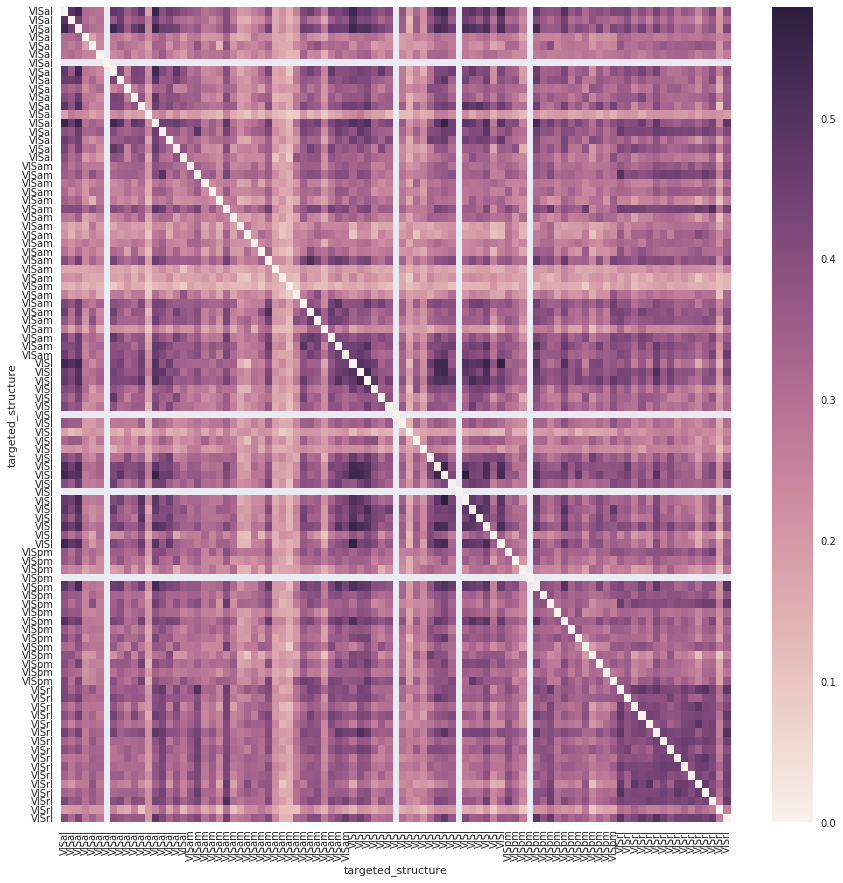

In [479]:
plt.figure(figsize=(15,15))
sns.heatmap(kt_all,vmin=0)


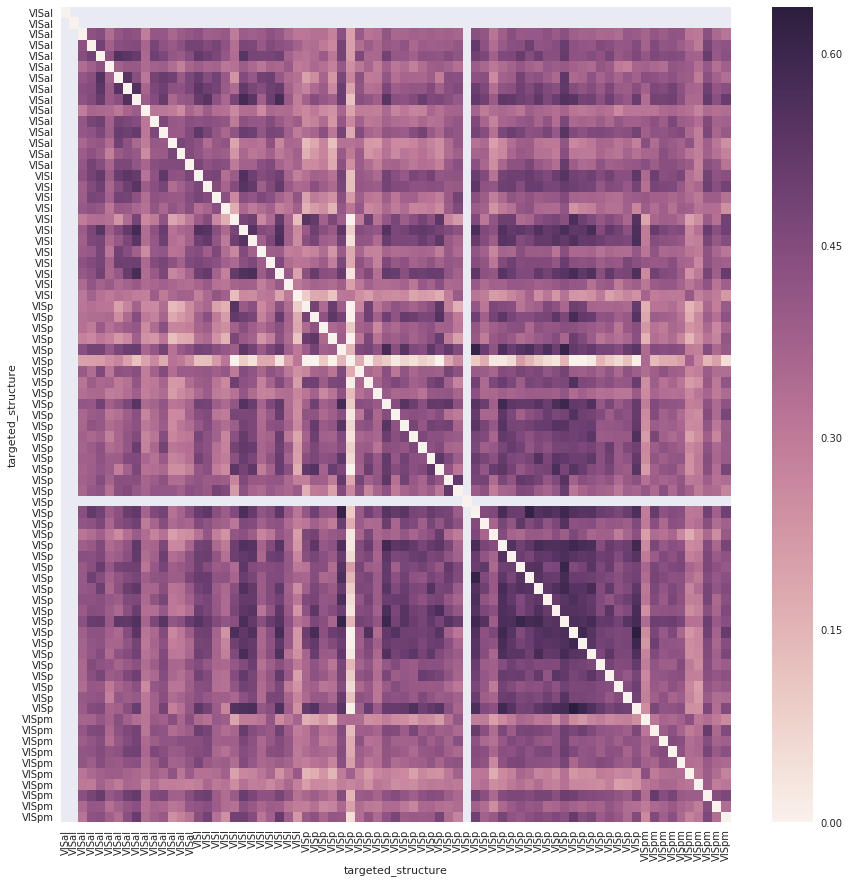

In [483]:
plt.figure(figsize=(15,15))
sns.heatmap(kt_all2,vmin=0)

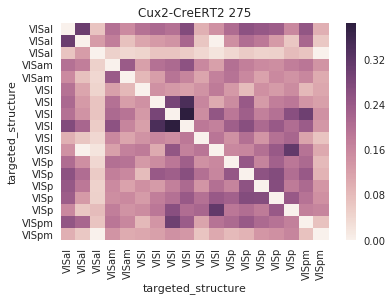

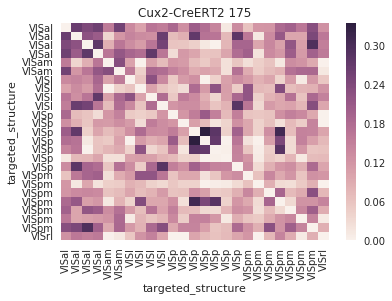

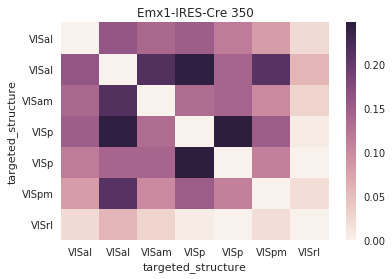

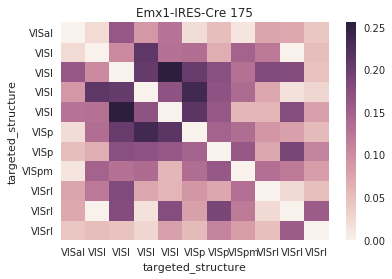

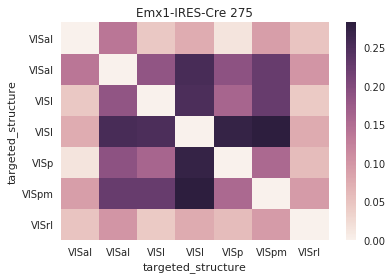

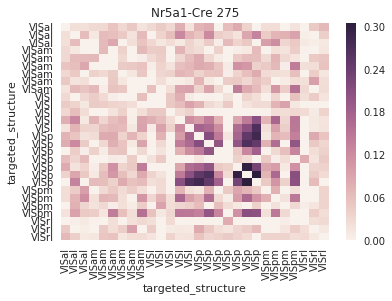

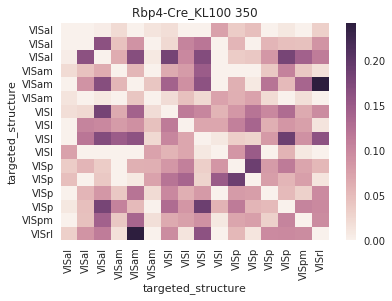

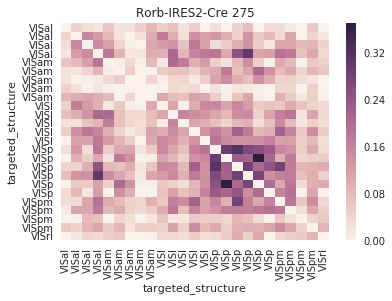

In [224]:
kt_dfs=get_kt_matrix(just_nonzeros,'targeted_structure')

In [ ]:
# to do: modify get_experiments_grouped so that it takes into account the valid_stimuli columns

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE, MDS
from sklearn.decomposition import PCA

In [ ]:
def get_unfolded_rsm(exps_grouped):
    """Takes the result of get_experiments_grouped and performs a 2D embedding on the rsms.
    Output: 2D numpy array of length number_experiments"""
    n_stim = exps_grouped.loc[0,'rsm'].shape[0]
    matrix_to_embed = np.vstack(
                        exps_grouped.rsm.apply( # apply this function to each rsm
                                scipy.spatial.distance.squareform))
        
    return matrix_to_embed

In [ ]:
def scatter_viz(to_plot,exps_grouped):
    
    plt.subplots_adjust(bottom = 0.1)
    plt.subplots_adjust(bottom = 0.1)

    areas = exps_grouped.targeted_structure
    
    for area in areas.unique():

        plt.scatter(
            to_plot[areas.values==area, 0], to_plot[areas.values==area, 1], marker = 'o'
            )

    plt.legend(areas.unique())

In [ ]:
to_embed = get_unfolded_rsm(exps_grouped)

Reduce dimensions with PCA then run tsne

In [ ]:
se = SpectralEmbedding(n_components = 10)
se_rsm = se.fit_transform(to_embed)

In [ ]:
tsne = TSNE(perplexity=5.0,metric=)
to_plot = tsne.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = LocallyLinearEmbedding(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = SpectralEmbedding(n_components=3)
to_plot = method.fit_transform(to_embed)

pca = PCA(n_components=2, whiten=False)
to_plot = pca.fit_transform(to_plot)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = PCA(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = MDS(n_components=2,eps = 1e-1)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

Or let's try to visualize the kts with MDS

In [184]:
kt_df = kt_dfs[-1]
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_df.values)
to_plot = results.embedding_

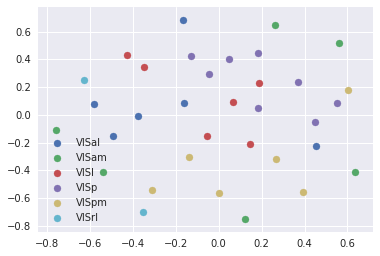

In [440]:

plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_df.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [441]:

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_all.values)
to_plot = results.embedding_

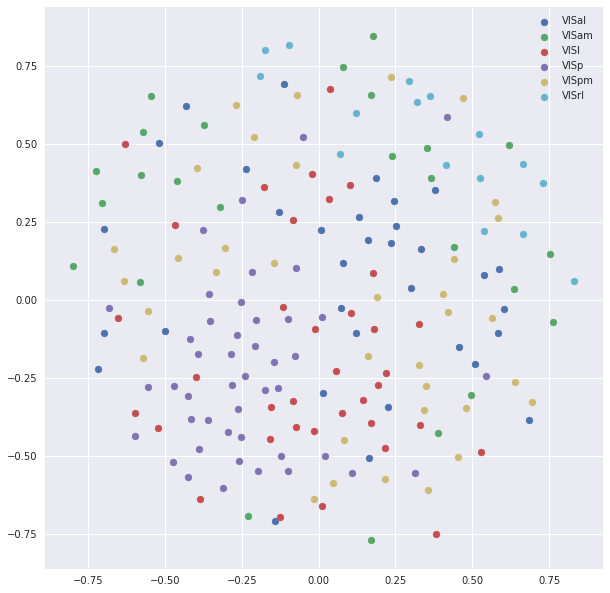

In [445]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_all.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [446]:
exps_grouped.head()

,cre_line,imaging_depth,targeted_structure,rsm
0,Cux2-CreERT2,275,VISal,"[[0.0, 14.0271879134, 17.7364615024, 17.471313..."
1,Cux2-CreERT2,275,VISal,"[[0.0, 19.7863268783, 24.5694978749, 20.453725..."
2,Cux2-CreERT2,275,VISal,"[[0.0, 10.065717023, 10.2442107709, 10.3606364..."
3,Cux2-CreERT2,275,VISal,"[[0.0, 19.5142452541, 20.1135017267, 20.266742..."
4,Cux2-CreERT2,275,VISal,"[[0.0, 12.7419734687, 12.0693315323, 11.451070..."


In [ ]:
exps_grouped['targeted_structure'].unique()

In [ ]:
available_targeted_structures=exps[(exps.cre_line==cre_line) & (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
available_targeted_structures

In [ ]:
for cre_line in cre_lines
sns.heatmap(kt_df)
plt.title(cre_lines+imaging_depths)

In [ ]:
np.fill_diagonal(kt_matrix,0)
sns.heatmap(kt_matrix)

In [ ]:
rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsm.mean()

In [ ]:
to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],index=['cre_line','imaging_depth','targeted_structure','rsm'])

In [ ]:
exps_grouped=exps_grouped.append(to_add.T)

In [ ]:
exps_grouped.head()